In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import os 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

In [3]:
sheet = pd.read_excel('data_input_auto/山东汽油裂解差_残差拟合.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
sheet.columns 

Index(['山东汽油裂解差拟合残差/中国独立炼厂汽油库存', '中国汽油社会库存4周环差', 'WESTPAC中国经济惊喜指数',
       '汽油情绪指数/8WMA', 'A股餐饮旅游指数60日环比', '中国独立炼厂汽油库存', 'WTI连1合约价格（路透）',
       '上证综指收盘价'],
      dtype='object')

In [4]:
last_day = sheet['山东汽油裂解差拟合残差/中国独立炼厂汽油库存'].last_valid_index()


future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet = sheet.sort_index()

fill_methods = {'中国汽油社会库存4周环差': 'interpolate',
                'WESTPAC中国经济惊喜指数': 'interpolate',
                '汽油情绪指数/8WMA': 'interpolate',
                'A股餐饮旅游指数60日环比': 'interpolate',
                '中国独立炼厂汽油库存': 'interpolate',
                '上证综指收盘价':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '山东汽油裂解差拟合残差/中国独立炼厂汽油库存'] = sheet.loc[:last_day, '山东汽油裂解差拟合残差/中国独立炼厂汽油库存'].interpolate(method='linear')


In [5]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/wti_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['wti原油期货价格'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,WTI原油期货价格预测
19,2025-05-01,61.27
18,2025-05-02,59.55
17,2025-05-05,60.43
16,2025-05-06,60.82
15,2025-05-07,61.80


In [6]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', 'WTI原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['WTI连1合约价格（路透）'] = sheet_daily['WTI连1合约价格（路透）'].fillna(sheet_daily['WTI原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['WTI原油期货价格预测'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [7]:

#################################  因子处理  #################################
sheet['中国汽油社会库存4周环差_提前30天'] = sheet['中国汽油社会库存4周环差'].shift(30)
sheet['WESTPAC中国经济惊喜指数_提前20天'] = sheet['WESTPAC中国经济惊喜指数'].shift(20)
sheet['汽油情绪指数/8WMA_提前20天'] = sheet['汽油情绪指数/8WMA'].shift(20)
sheet['A股餐饮旅游指数60日环比_提前45天'] = sheet['A股餐饮旅游指数60日环比'].shift(45)
sheet['上证综指收盘价_提前45天'] = sheet['上证综指收盘价'].shift(45)

# 逆序
# sheet['美国首次申领失业金人数/4WMA_提前30天_逆序'] = reverse_column(sheet, '美国首次申领失业金人数/4WMA_提前30天')
# 截取部分数据 
sheet['中国汽油社会库存4周环差_提前30天_2024-01-01'] = np.where(
    sheet.index >= pd.Timestamp('2024-01-01'),
    sheet['中国汽油社会库存4周环差_提前30天'],
    np.nan
)

sheet['WTI连1合约价格（路透）_逆序'] = reverse_column(sheet, 'WTI连1合约价格（路透）')

################################# 数据筛选  #################################
sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
# 筛选日期大于 2024-01-01 的行
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]
# 重置索引,使其从0开始 
sheet_daily = sheet_daily.reset_index(drop=True)
# 删除 在 last_day 之前 预测标的 为 空值的 行
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['山东汽油裂解差拟合残差/中国独立炼厂汽油库存'].notna())
]

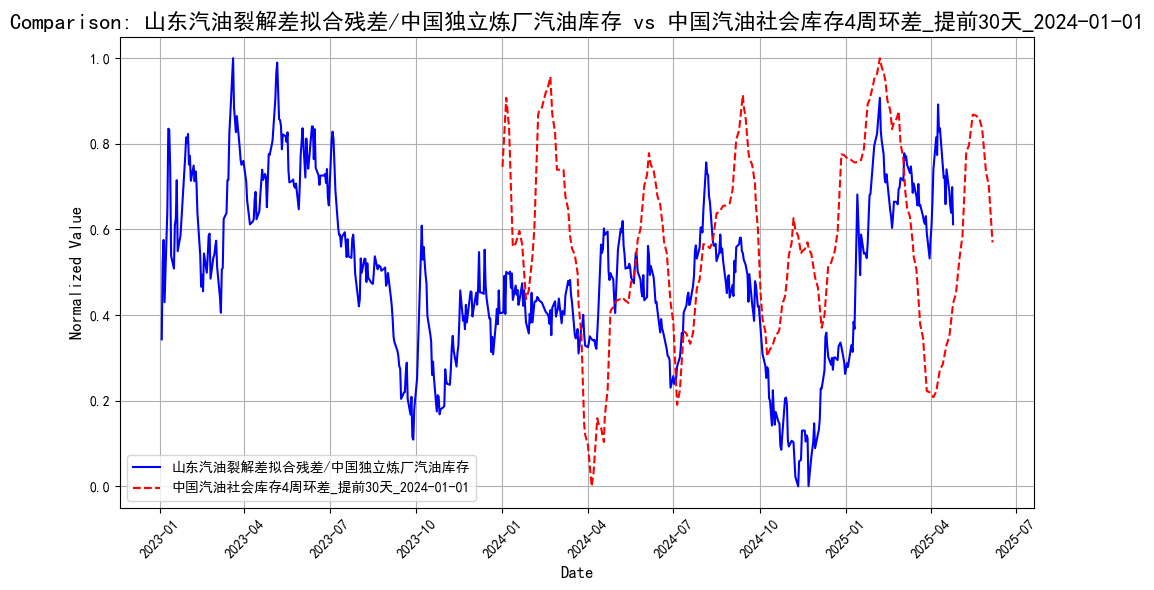

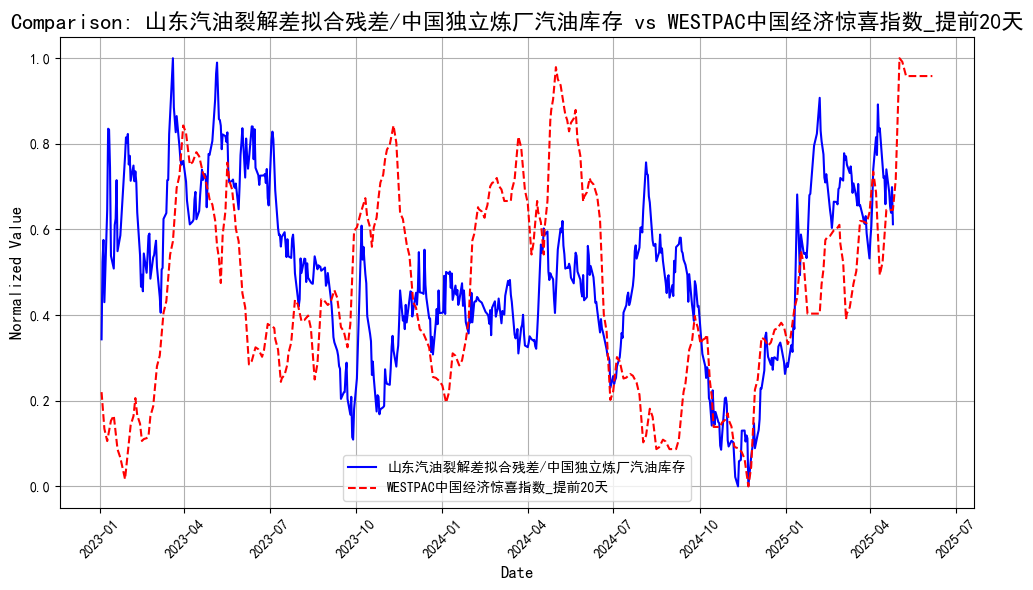

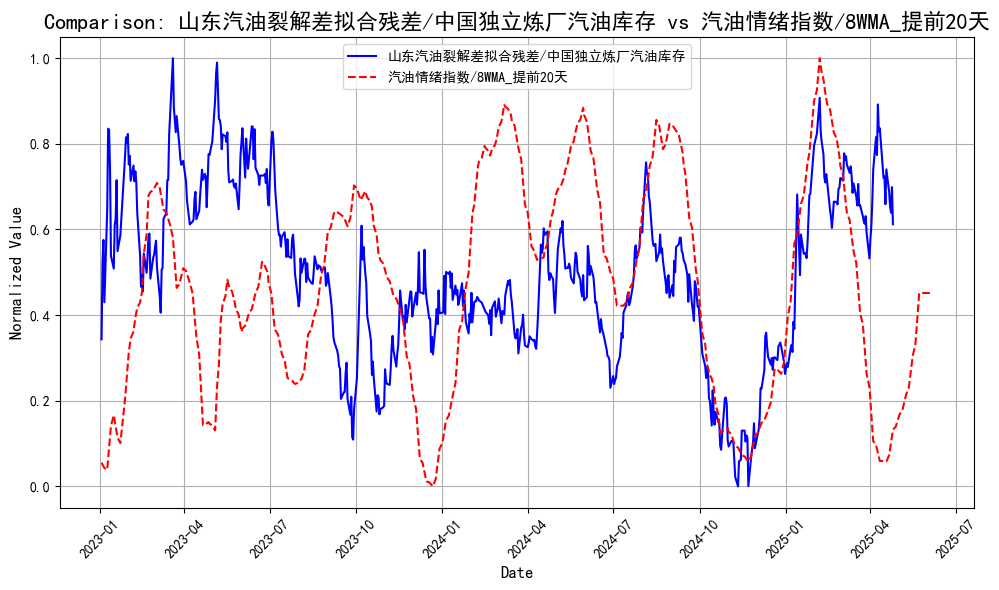

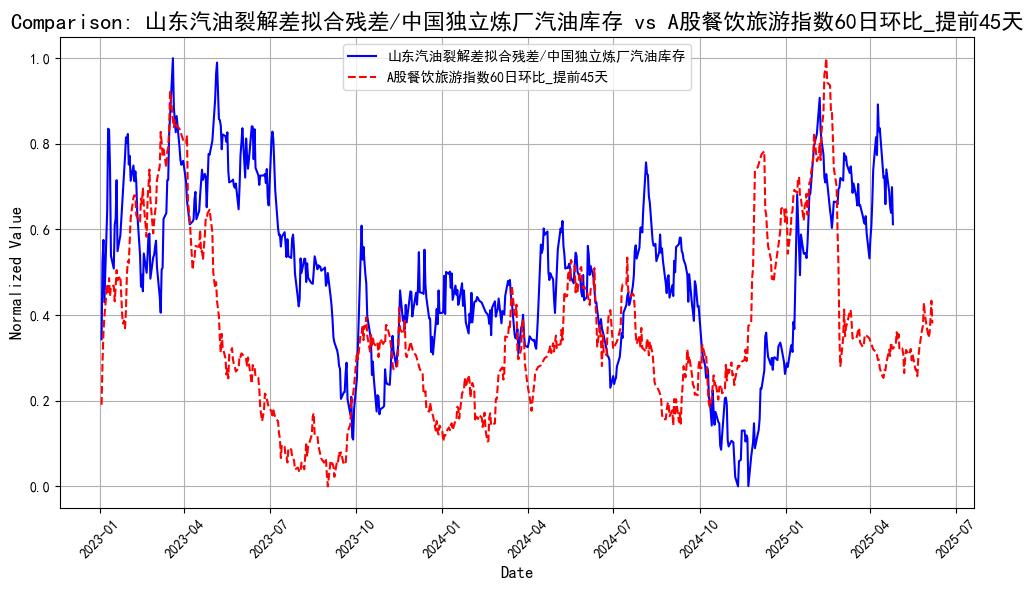

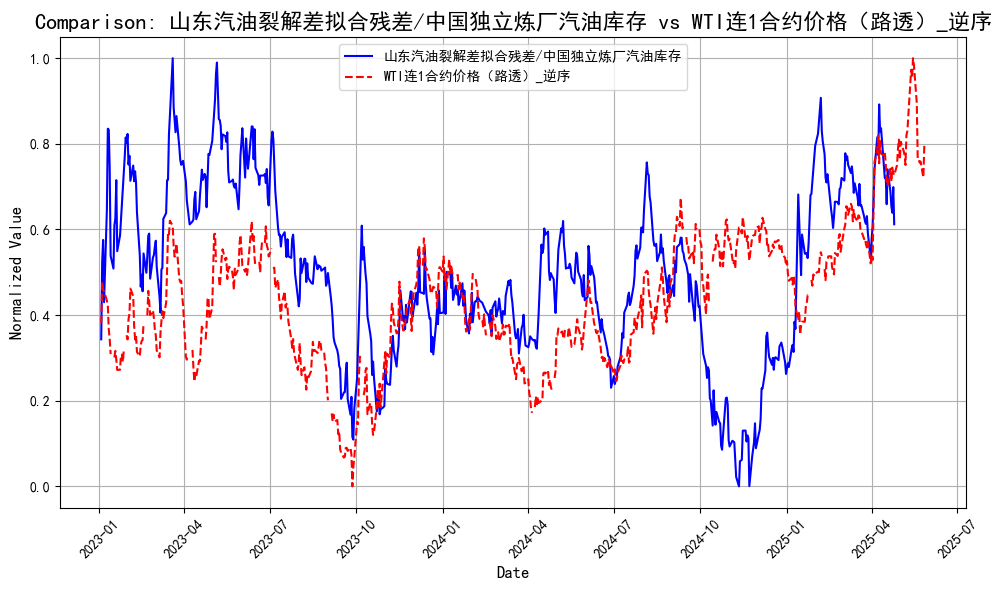

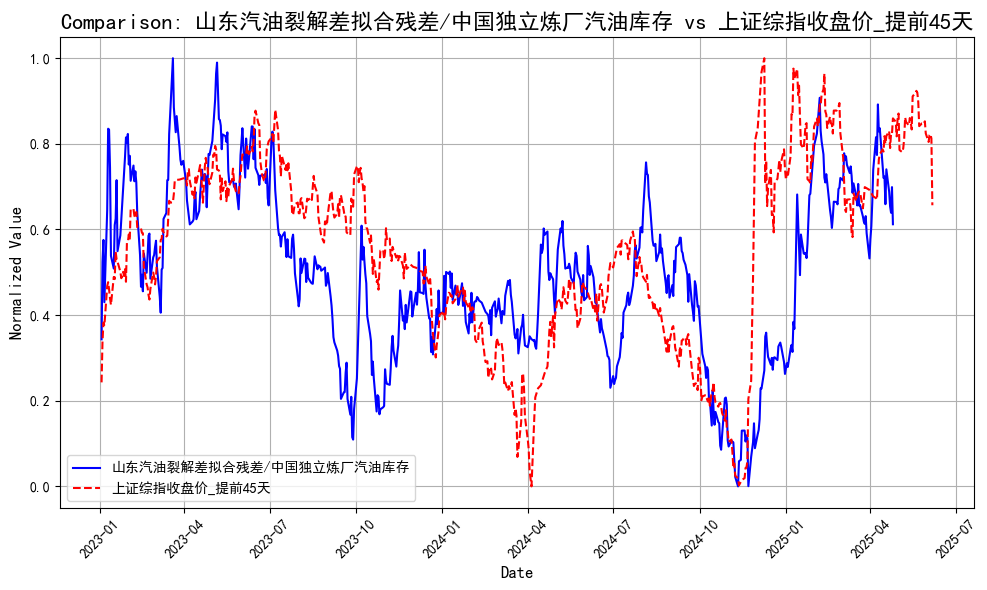

In [8]:
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='山东汽油裂解差拟合残差/中国独立炼厂汽油库存', 
    compare_cols=[
        '中国汽油社会库存4周环差_提前30天_2024-01-01',
       'WESTPAC中国经济惊喜指数_提前20天', 
       '汽油情绪指数/8WMA_提前20天', 
       'A股餐饮旅游指数60日环比_提前45天',
       'WTI连1合约价格（路透）_逆序',
       '上证综指收盘价_提前45天'
       ]
)

In [9]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 10
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

# 因子集
feature_columns = [
        '中国汽油社会库存4周环差_提前30天_2024-01-01',
       'WESTPAC中国经济惊喜指数_提前20天', 
       '汽油情绪指数/8WMA_提前20天', 
       'A股餐饮旅游指数60日环比_提前45天',
       'WTI连1合约价格（路透）_逆序',
       '上证综指收盘价_提前45天'
]
# 预测目标column
predict_column = '山东汽油裂解差拟合残差/中国独立炼厂汽油库存'

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

# 正则化所有input 选择standard 因为金融数据 会超过过往极值的问题
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

# 创建DMatrix对象,设置样本权重以降低异常值的影响
train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90) 
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0 
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 较小的学习率
    'max_depth': 4,  # 控制树的深度防止过拟合
    'min_child_weight': 3,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.8,  # 特征随机采样
    'gamma': 0.1,  # 控制分裂
    'reg_alpha': 0.1,  # L1正则化
    'reg_lambda': 1.0,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}

# 训练模型，使用早停策略，最大训练轮数
num_boost_round = 1000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=300 # 每100轮输出一次评估信息
)

# 预测
y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

# 计算 MSE 和 R² 分数
train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:295.25242	train-rmse:290.15655


[300]	eval-rmse:89.03692	train-rmse:93.13736


[600]	eval-rmse:130.21077	train-rmse:66.84410


[900]	eval-rmse:146.65384	train-rmse:54.46893


[999]	eval-rmse:151.48517	train-rmse:51.36809


训练集 MSE (DMatrix): 2704.1143, 训练集 R² (DMatrix): 0.9698
测试集 MSE (DMatrix): 22947.7564, 测试集 R² (DMatrix): -4.1477


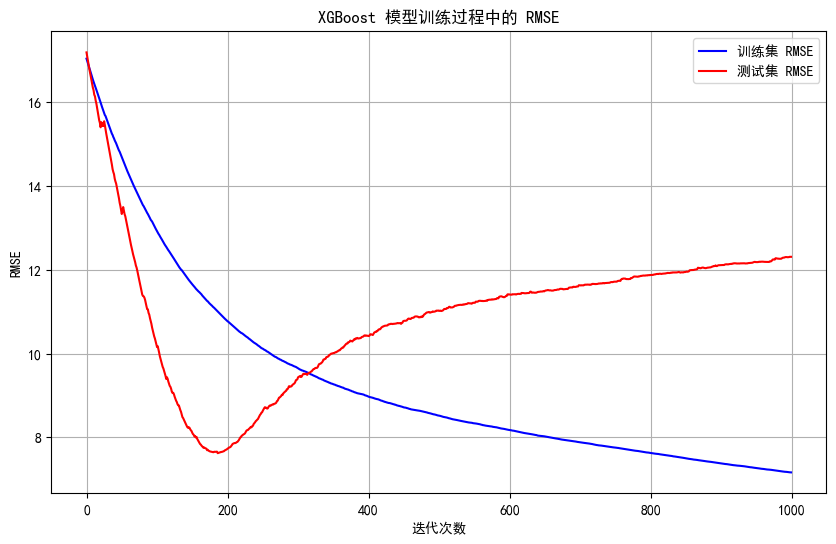

In [10]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################

# 确保数据拼接后索引是连续的，防止数据对不齐
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

# 对全部数据进行预测（X_train + X_test）
y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

# 打印结果
print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:297.33873


[100]	train-rmse:168.99330

[200]	train-rmse:116.89790


[300]	train-rmse:93.83646

[400]	train-rmse:80.49116

[500]	train-rmse:72.27799


[600]	train-rmse:66.56469


[700]	train-rmse:61.96777


[800]	train-rmse:57.97470

[900]	train-rmse:54.46727


[999]	train-rmse:51.56311

[999]	train-rmse:51.19161


全部数据 MSE: 2658.7539, 全部数据 R²: 0.9703

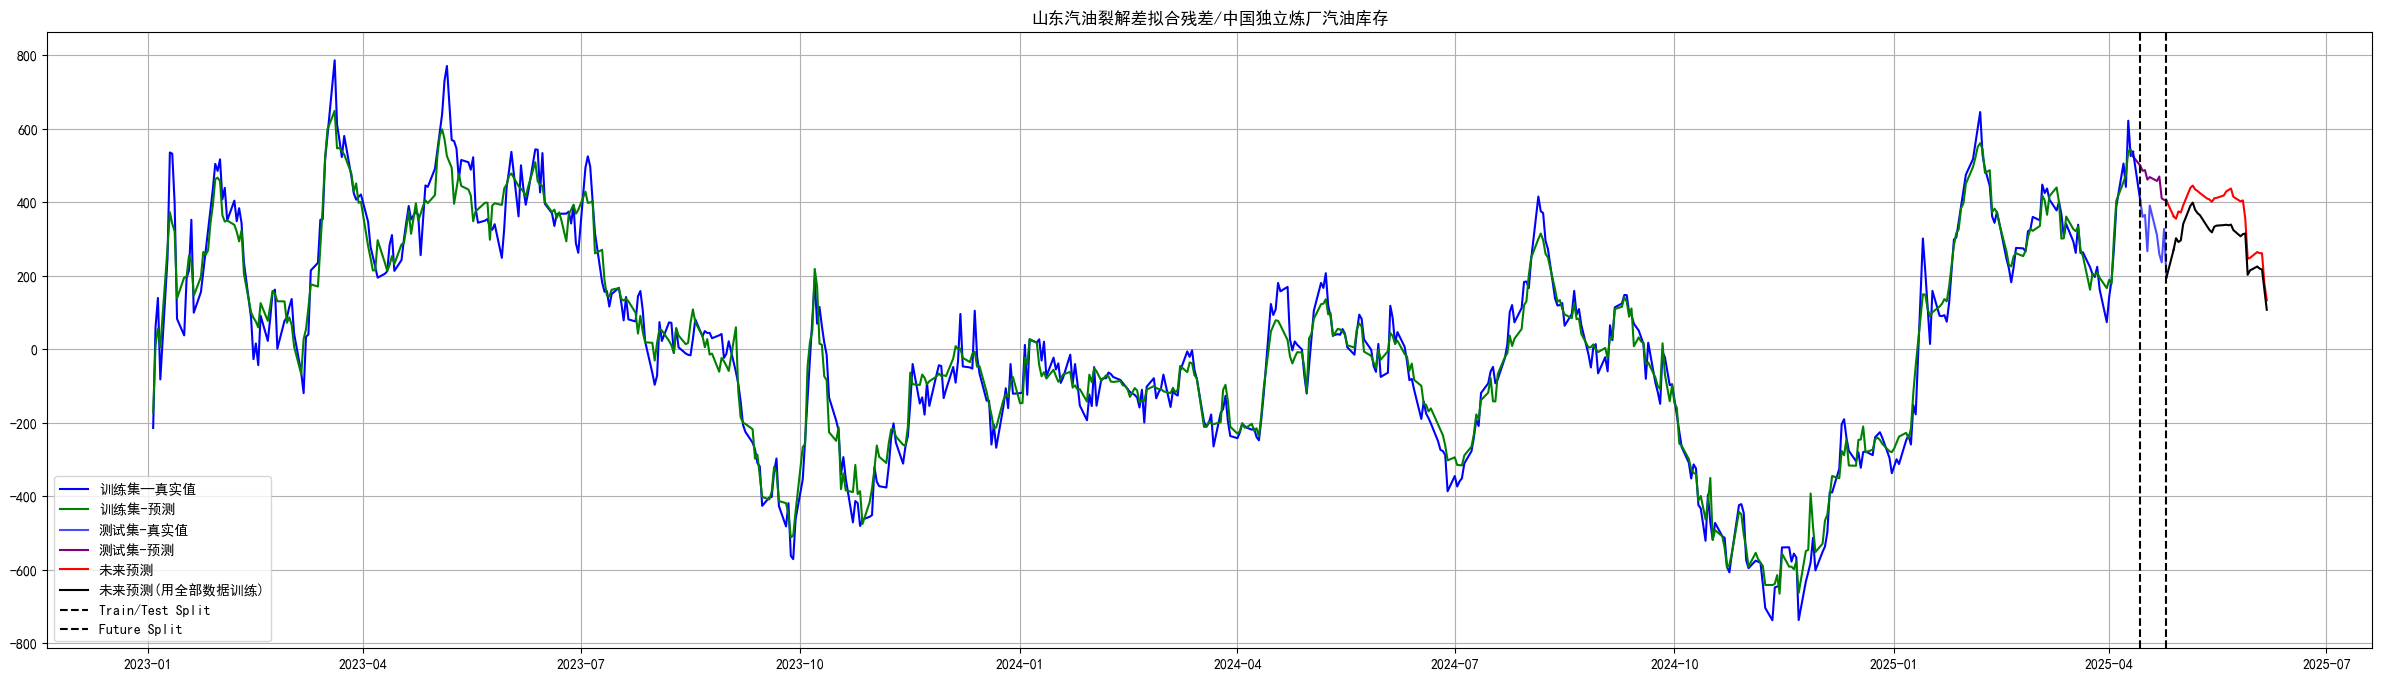

In [12]:
################################# 可视化 #################################
'''
蓝色：真实数据
绿色：训练集数据 预测 模型表现
紫色：测试集数据 预测 模型表现
红线：未来集数据 预测 正常预测 
黑线：未来集数据 预测 全部数据训练预测 
'''
# 创建一个新的图形
plt.figure(figsize=(30, 8))

# 训练集和测试集的连接点(预测值)
train_last_date = train_data['Date'].iloc[-1]
test_first_date = test_data['Date'].iloc[0]
train_last_value = y_train_pred_dmatrix[-1]
test_first_value = y_test_pred_dmatrix[0]

# 训练集和测试集的连接点(真实值)
train_last_date_real = train_data['Date'].iloc[-1]
test_first_date_real = test_data['Date'].iloc[0]
train_last_value_real = y_train.iloc[-1]
test_first_value_real = y_test.iloc[0]

# 测试集和未来集的连接点(普通预测)
test_last_date = test_data['Date'].iloc[-1]
future_first_date = future_data['Date'].iloc[0]
test_last_value = y_test_pred_dmatrix[-1]
future_first_value = future_data['预测值'].iloc[0]

# 测试集和未来集的连接点(全量预测)
test_last_date_all = test_data['Date'].iloc[-1]
future_first_date_all = future_data['Date'].iloc[0]
test_last_value_all = y_test.iloc[-1]
future_first_value_all = future_data['预测值_全量'].iloc[0]

# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加连接线
plt.plot([train_last_date, test_first_date], [train_last_value, test_first_value], color='purple')
plt.plot([test_last_date, future_first_date], [test_last_value, future_first_value], color='red')
plt.plot([train_last_date_real, test_first_date_real], [train_last_value_real, test_first_value_real], color='blue')
plt.plot([test_last_date_all, future_first_date_all], [test_last_value_all, future_first_value_all], color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('山东汽油裂解差拟合残差/中国独立炼厂汽油库存')
plt.legend()
plt.grid(True)
plt.show()


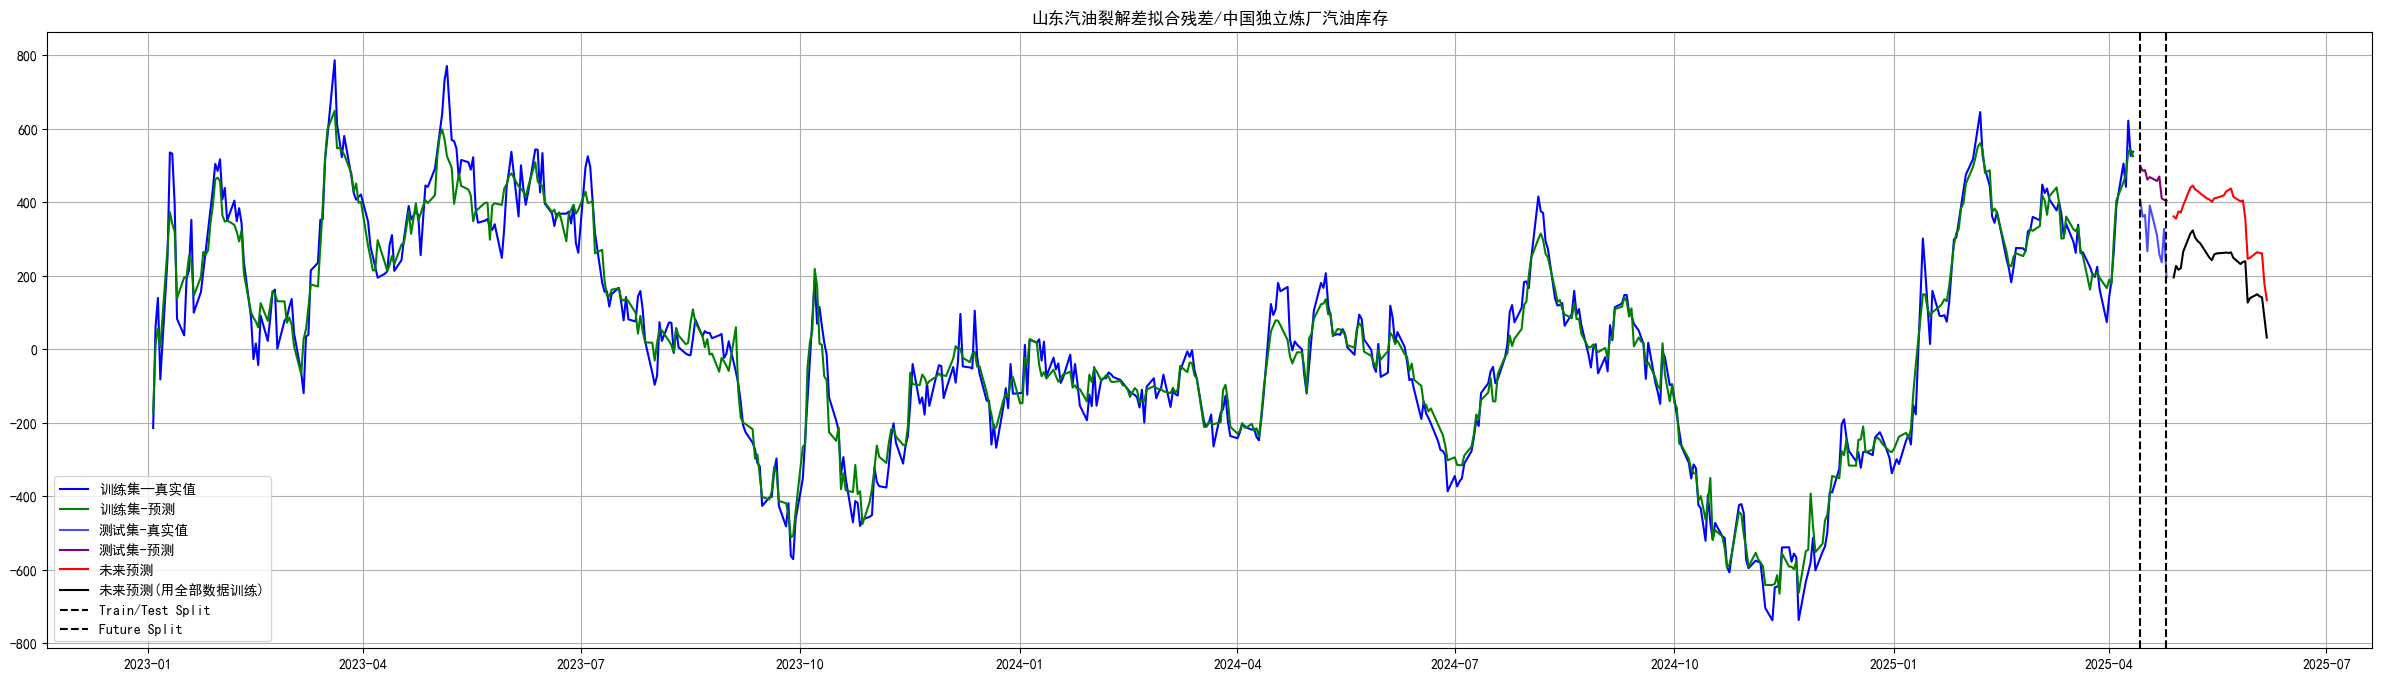

In [13]:
################################# 可视化 #################################
'''
蓝色：真实数据
绿色：训练集数据 预测 模型表现
紫色：测试集数据 预测 模型表现
红线：未来集数据 预测 正常预测 
黑线：未来集数据 预测 全部数据训练预测 
'''

# 创建一个新的图形
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

plt.title('山东汽油裂解差拟合残差/中国独立炼厂汽油库存')
plt.legend()
plt.grid(True)
plt.show()


---

In [14]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/山东汽油裂解差拟合残差-中国独立炼厂汽油库存_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/山东汽油裂解差拟合残差-中国独立炼厂汽油库存_月度数据.xlsx', index=False,float_format= '%.4f')

---

In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "山东汽油裂解差拟合残差/中国独立炼厂汽油库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "山东汽油裂解差拟合残差/中国独立炼厂汽油库存"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/04/30)
数据已成功更新到Excel文件
